In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

Load models

In [8]:
nba_clustering_models = load_pickle('nba_clustering_models')
nba_clustering_models.keys()

dict_keys(['pre_pca_pipe', 'pca', 'pre_cluster_scaler', 'cluster_dict'])

In [9]:
cluster_dict = nba_clustering_models['cluster_dict']

Read data

In [10]:
df = pd.read_csv('nba_cleaned.csv')
df.shape

(1774, 116)

In [11]:
labels = df['player_cluster'].values

In [12]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%', 'Transition_Poss%']

In [13]:
X = df[poss_weights_cols].copy()

In [14]:
X_transformed = X.copy()
queues = ['pre_pca_pipe', 'pca', 'pre_cluster_scaler']
for step in queues:
    X_transformed = nba_clustering_models[step].transform(X_transformed)

In [15]:
tsne = TSNE(perplexity=20, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

## Function

In [17]:
def plot_players(lookup_idx, labels=labels, X_tsne=X_tsne, df=df, cluster_dict=cluster_dict):
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster_index = [j for j in range(len(labels)) if labels[j] == i]
        plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                    label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
    plt.legend()
    plt.title(f'TSNE Visualization (Spectral Clustering based on {n_clusters} PCA features)')
    for idx in lookup_idx:
        player_coord = X_tsne[idx]
        plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
        plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                     player_coord, alpha=0.6)

## Case Study

### 2022 Celtics Playoff Run

Celtics

In [18]:
lookup_players = ['Jayson Tatum', 'Jaylen Brown', 'Marcus Smart',
                  'Al Horford', 'Robert Williams III']
lookup_idx = df[df['Player'].isin(lookup_players)].index

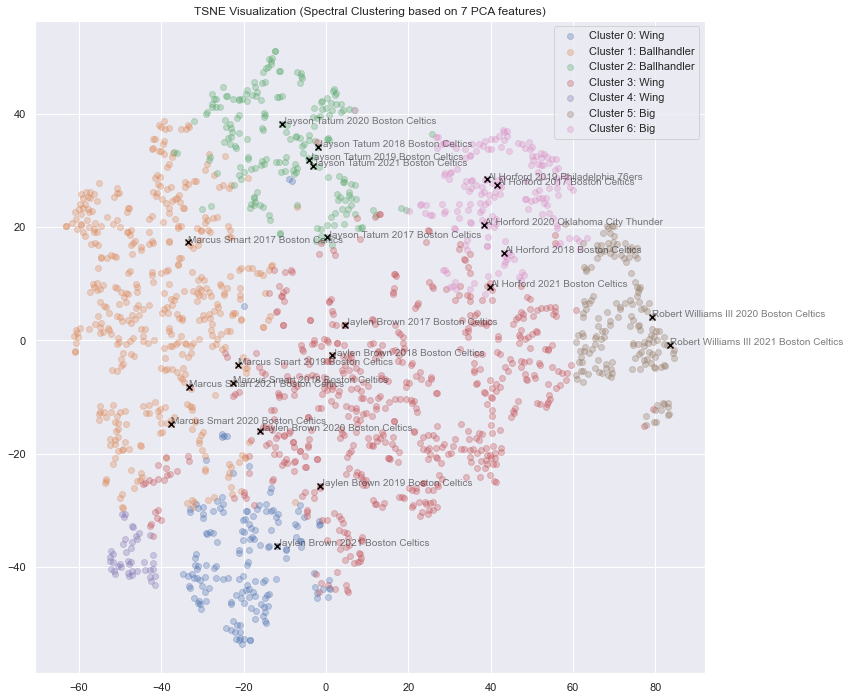

In [20]:
figsize(12, 12)
plot_players(lookup_idx)

Warriors

In [21]:
lookup_players = ['Stephen Curry', 'Klay Thompson', 'Draymond Green',
                  'Andrew Wiggins', 'AndrewWiggins', 'Jordan Poole']
lookup_idx = df[df['Player'].isin(lookup_players)].index

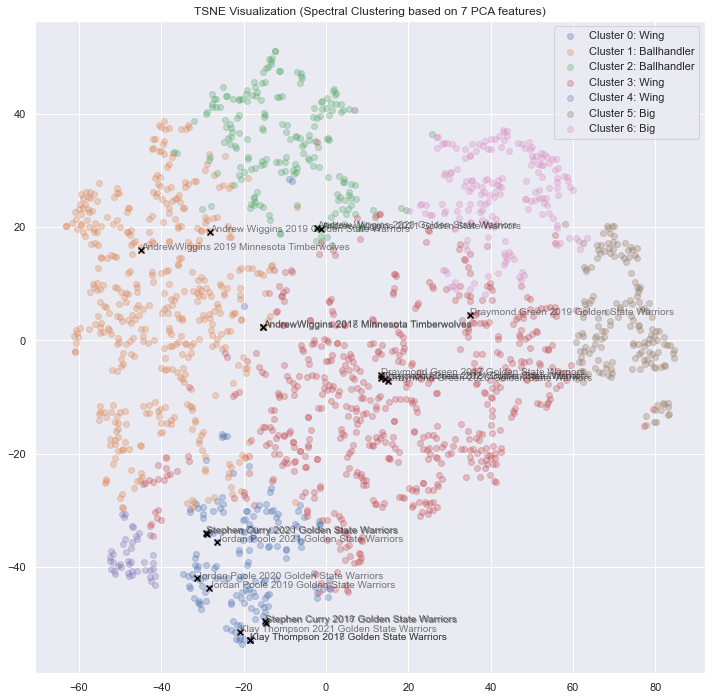

In [22]:
figsize(12, 12)
plot_players(lookup_idx)

Celtics Playoff Opponents

In [23]:
lookup_players = ['Kyrie Irving', 'Kevin Durant',
                  'Giannis Antetokoumpo', 'Jrue Holiday',
                  'Jimmy Butler', 'Bam Adebayo']
lookup_idx = df[df['Player'].isin(lookup_players)].index

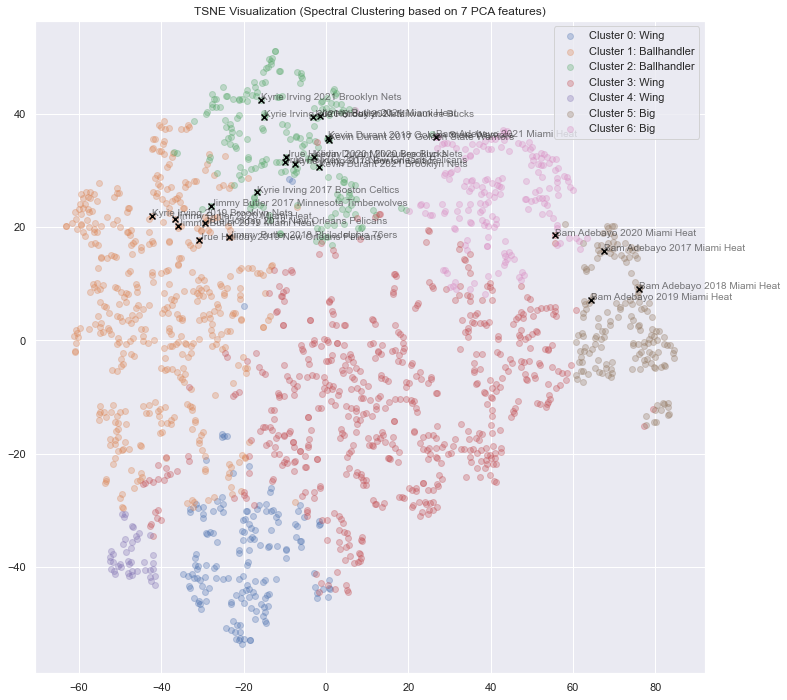

In [24]:
figsize(12, 12)
plot_players(lookup_idx)

### Cluster 4: Big Man Fall into 'Ballhandling Category'

In [25]:
df[df['player_cluster'] == 2].sort_values('P&R Ball Handler_Poss%')\
[['Player', 'Season', 'P&R Ball Handler_Poss%', 'P&R Roll Man_Poss%']].head(20)

,Player,Season,P&R Ball Handler_Poss%,P&R Roll Man_Poss%
1690,Karl-Anthony Towns,2021,0.015831,0.134565
1636,Christian Wood,2021,0.019553,0.181564
242,Michael Beasley,2017,0.026999,0.131880
656,Julius Randle,2018,0.029745,0.071530
254,Rondae Hollis-Jefferson,2017,0.033369,0.102260
1135,Danilo Gallinari,2020,0.044326,0.109929
827,Eric Paschall,2019,0.045340,0.047859
937,Julius Randle,2019,0.045986,0.099766
1170,Eric Paschall,2020,0.048913,0.119565
145,Danilo Gallinari,2017,0.049180,0.068852


In [26]:
lookup_idx = df[df['player_cluster'] == 2].sort_values('P&R Ball Handler_Poss%')\
             [['Player', 'Season', 'P&R Ball Handler_Poss%', 'P&R Roll Man_Poss%']]\
                                          .head(20).index

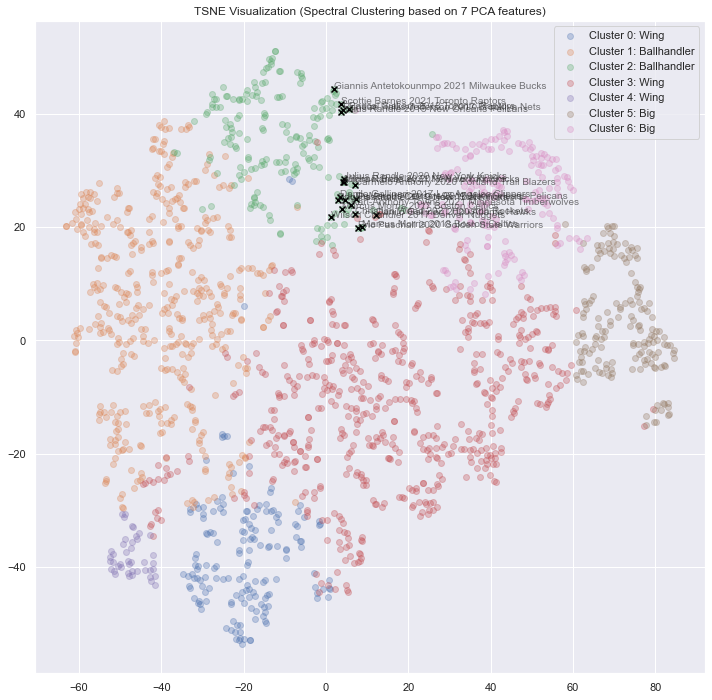

In [27]:
figsize(12, 12)
plot_players(lookup_idx)

Karl-Anthony Towns

In [28]:
for col in df.columns:
    if 'Poss%' in col:
        num = df[(df['player_cluster'] == 2) & 
                 (df['Player'] == 'Karl-Anthony Towns')].loc[1690][col]
        print(col, f'{num:.1%}')

Spot Up_Poss% 21.4%
Transition_Poss% 11.6%
P&R Ball Handler_Poss% 1.6%
Offensive Rebounds (put backs)_Poss% 8.9%
Cut_Poss% 5.9%
Hand Off_Poss% 2.4%
Isolation_Poss% 13.4%
Off Screen_Poss% 5.5%
P&R Roll Man_Poss% 13.5%
Post-Up_Poss% 15.7%
Miscellaneous_Poss% 6.9%


DeMarcus Cousins

In [29]:
for col in df.columns:
    if 'Poss%' in col:
        num = df[(df['player_cluster'] == 2) & 
                 (df['Player'] == 'DeMarcus Cousins')].loc[293][col]
        print(col, f'{num:.1%}')

Spot Up_Poss% 21.8%
Transition_Poss% 14.6%
P&R Ball Handler_Poss% 6.0%
Offensive Rebounds (put backs)_Poss% 6.8%
Cut_Poss% 4.5%
Hand Off_Poss% 1.6%
Isolation_Poss% 13.8%
Off Screen_Poss% 3.8%
P&R Roll Man_Poss% 9.1%
Post-Up_Poss% 18.0%
Miscellaneous_Poss% 8.0%


In [30]:
lookup_players = ['Karl-Anthony Towns', 'DeMarcus Cousins']
lookup_idx = df[df['Player'].isin(lookup_players)].index

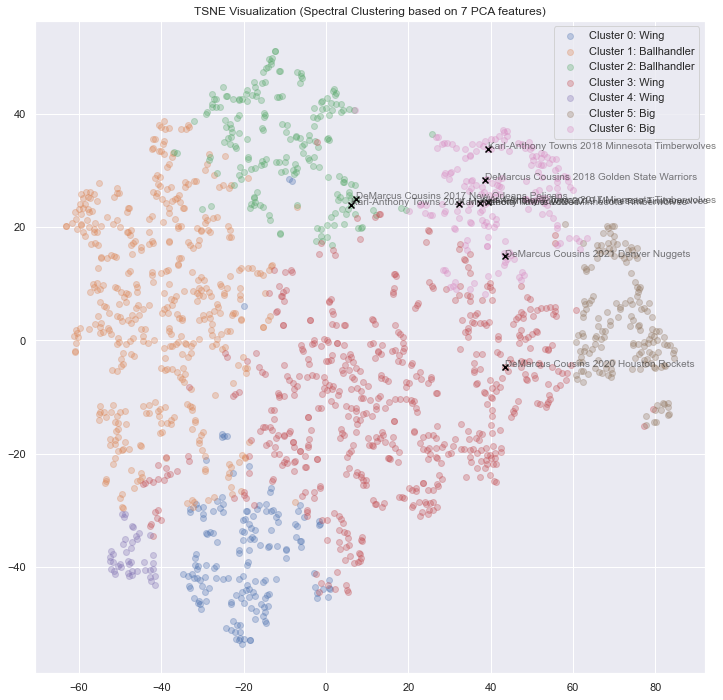

In [31]:
figsize(12, 12)
plot_players(lookup_idx)

### Three-Type Players / Players Jump b/w Ballhandler and Big

In [32]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
127,DeMarcus Cousins,"{2, 3, 6}","{Big, Wing, Ballhandler}",3
210,Harrison Barnes,"{2, 3, 6}","{Big, Wing, Ballhandler}",3
500,Rondae Hollis-Jefferson,"{2, 3, 5}","{Big, Wing, Ballhandler}",3
554,Tobias Harris,"{2, 3, 6}","{Big, Wing, Ballhandler}",3


In [33]:
temp[(temp['n_cluster'] == 2) & (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster
70,Carmelo Anthony,"{2, 6}","{Big, Ballhandler}",2
320,Julius Randle,"{2, 6}","{Ballhandler, Big}",2
326,Karl-Anthony Towns,"{2, 6}","{Ballhandler, Big}",2
607,Zion Williamson,"{2, 6}","{Ballhandler, Big}",2


In [34]:
lookup_players = ['Tobias Harris', 'Harrison Barnes']
lookup_idx = df[df['Player'].isin(lookup_players)].index

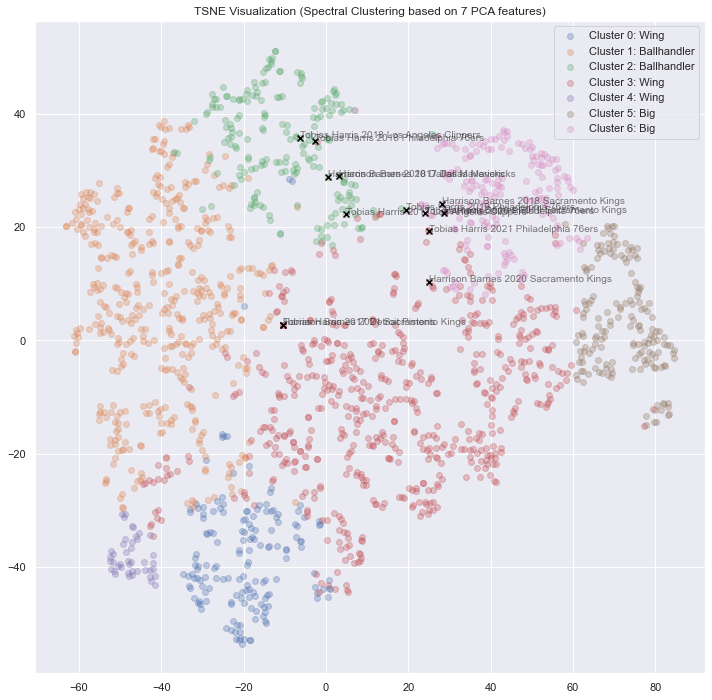

In [35]:
figsize(12, 12)
plot_players(lookup_idx)

In [36]:
lookup_players = ['Julius Randle', 'Carmelo Anthony']
lookup_idx = df[df['Player'].isin(lookup_players)].index

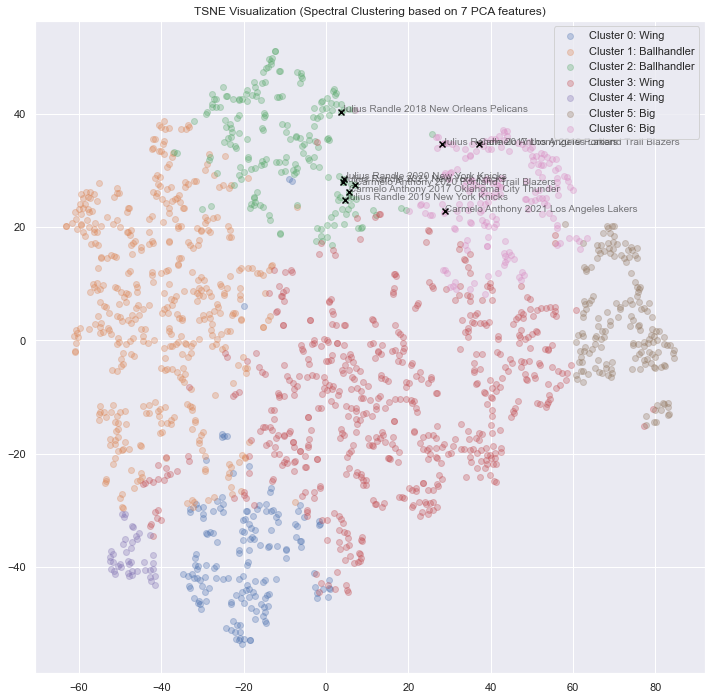

In [37]:
figsize(12, 12)
plot_players(lookup_idx)

In [38]:
lookup_players = ['Zion Williamson']
lookup_idx = df[df['Player'].isin(lookup_players)].index

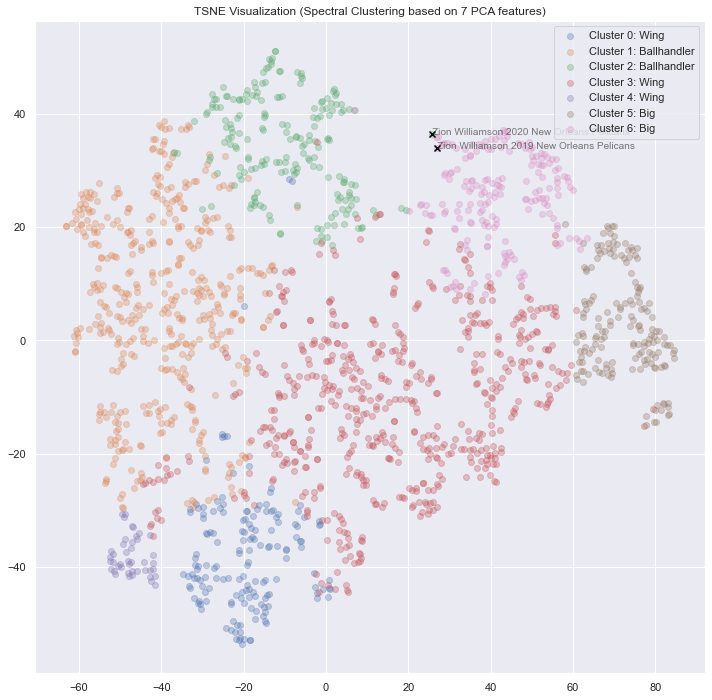

In [39]:
figsize(12, 12)
plot_players(lookup_idx)

In [40]:
lookup_players = ['Bruce Brown', 'Ben Simmons']
lookup_idx = df[df['Player'].isin(lookup_players)].index

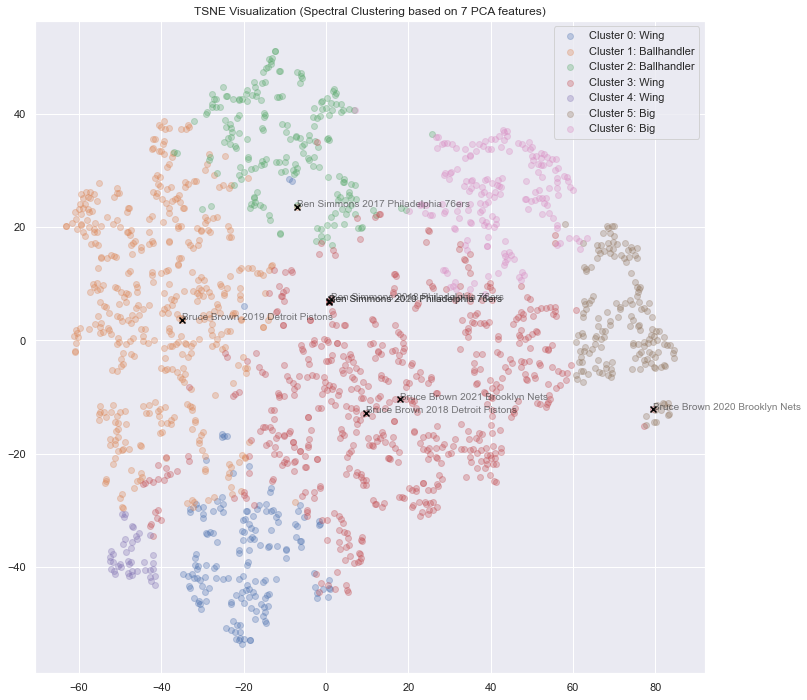

In [41]:
figsize(12, 12)
plot_players(lookup_idx)

In [42]:
lookup_players = ['Eric Paschall', 'Rondae Hollis-Jefferson']
lookup_idx = df[df['Player'].isin(lookup_players)].index

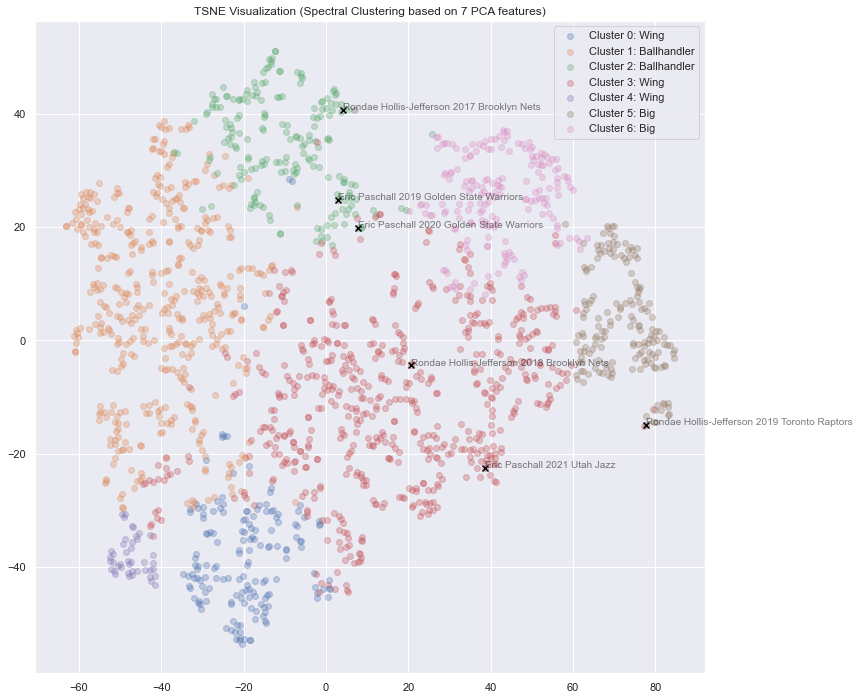

In [43]:
figsize(12, 12)
plot_players(lookup_idx)